In [1]:
import os
import pyboard
import time
import json
import numpy as np
from pylab import *
from matplotlib.animation import FuncAnimation

pb = None
%matplotlib inline

## helper functions

In [6]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res 

In [8]:
def get_spectrum():
    script = [
        'sp.read()',
        'print(list(sp.spectrum))'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return raw

### parameter for scanning

In [53]:
t_int_s =4*1e-1  # in second
print(t_int_s*1e6)

400000.0


## load the telescope

In [4]:
## find out the port that connects to SPM 32
result = os.popen('ls -l /dev/ttyUSB*').read()
result = result.strip('\n').split(' ')
port = result[-1]
print(port)

/dev/ttyUSB0


In [5]:
pb = None
try:
    pb = pyboard.Pyboard(port)
    pb.enter_raw_repl()  
except pyboard.PyboardError as e:
    print(e) 

In [54]:
script = [
    'from driver.c12880ma import C12880MA',
    'import board',
    'sp = C12880MA(trg=board.TRG, st=board.STA, clk=board.CLK, video=board.VID)',
    'sp.begin()',
    'sp.setIntegrationTime_s({})'.format(t_int_s),
    'print(list(sp.wavelengths))'
]

### plot the telescope's resulting spectra

(0.0, 4095.0)

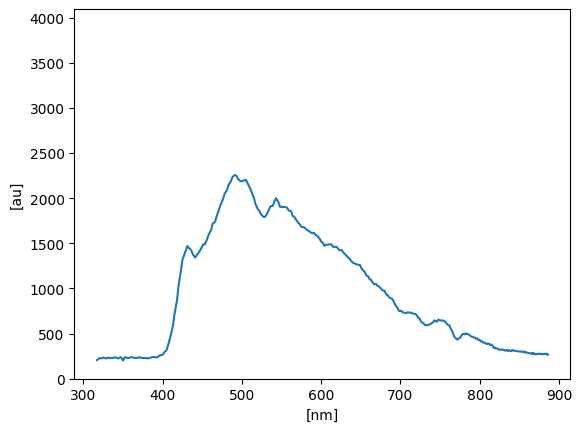

In [55]:
# nm = json.loads(run_on_board(script, wait_s=0.4, no_print=True))
data = get_spectrum()
plt.plot(nm,data)
plt.ylabel("[au]")
plt.xlabel("[nm]")
plt.ylim(0,4095)

In [26]:
print(np.min(nm),np.max(nm))

317.0 886.0


## load the ocean optics

In [32]:
# import seabreeze (use 'pyseabreeze')
import seabreeze.spectrometers as sb

In [33]:
devices = sb.list_devices()
print (devices)

[<SeaBreezeDevice STS:S03615>]


In [35]:
spec = sb.Spectrometer.from_serial_number("S03615")#STS-UV-L-100-400-SMA
# serial number
print (spec.serial_number)
# model
print (spec.model)
# number of pixels (as returned by seabreeze)
print (spec.pixels)
# set the integration time in microseconds
spec.integration_time_micros(400000)
time.sleep(2)

S03615
STS
1024


### plot the OceanOptics' resulting scan

665.6025696758672 182.79051208496094


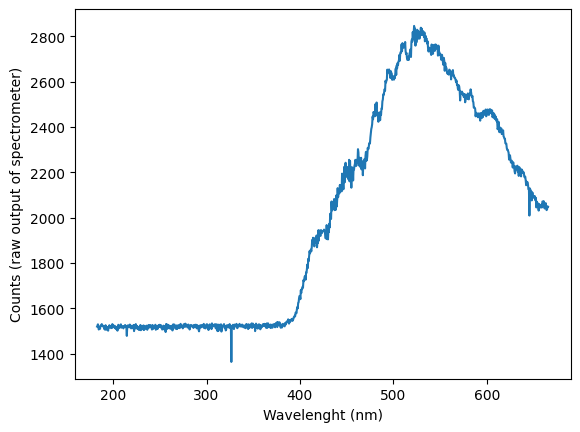

In [56]:
t_int_micros=t_int_s*1e6
spec.integration_time_micros(t_int_micros)
#spectrometer test
trial_num=1
trials=[]
for i_num in range(trial_num):
    wavelengths, intensities = spec.spectrum() # core function
    trials.append(intensities)
intensities=np.mean(trials,axis=0)
#
plt.plot(wavelengths,intensities)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
print (np.max(wavelengths),np.min(wavelengths))

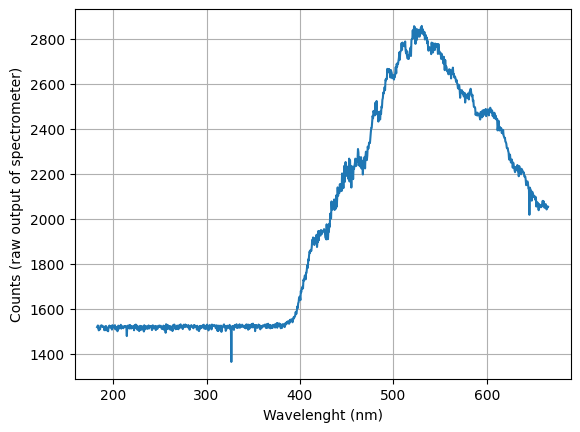

In [57]:
#get dark noise
dark_400ms_10=[]
for ii in range(10):
    wavelengths, intensities = spec.spectrum()
    dark_400ms_10.append(intensities)
    time.sleep(2)
dark_400ms_10=np.asarray(dark_400ms_10)
mean_dark_400ms_newDev2=np.mean(dark_400ms_10,axis=0)
plt.plot(wavelengths,mean_dark_400ms_newDev2)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()

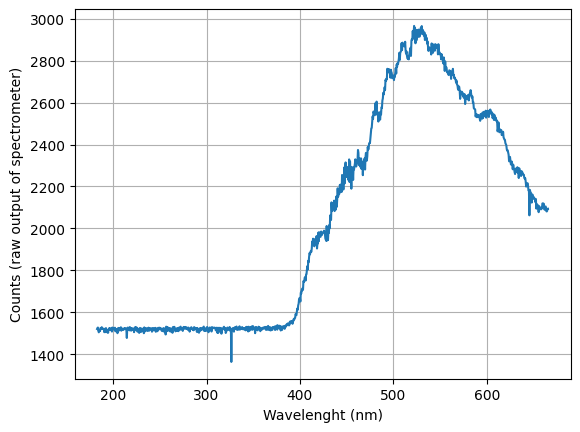

In [58]:
#get blue 430nm led spectrum
blue_430nm_400ms=intensities
blue_430nm_400ms=[]
for ii in range(10):
    wavelengths, intensities = spec.spectrum()
    blue_430nm_400ms.append(intensities)
    time.sleep(2)
blue_430nm_400ms=np.asarray(blue_430nm_400ms)
mean_blue_430nm_400ms=np.mean(blue_430nm_400ms,axis=0)
plt.plot(wavelengths,mean_blue_430nm_400ms)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()

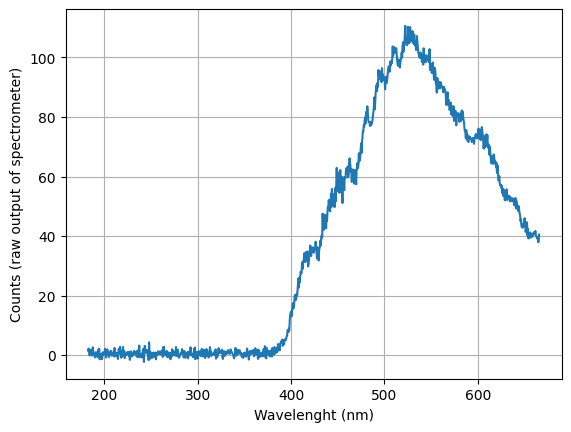

In [59]:
#blue 430nm 400ms exclude dark noise
blue_430nm_400ms_no_dark_noise=mean_blue_430nm_400ms-mean_dark_400ms_newDev2
plt.plot(wavelengths,blue_430nm_400ms_no_dark_noise)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()

## plot two results together

Text(0.5, 1.0, 'Calibration_tele_OO, int_t_400.0 ms')

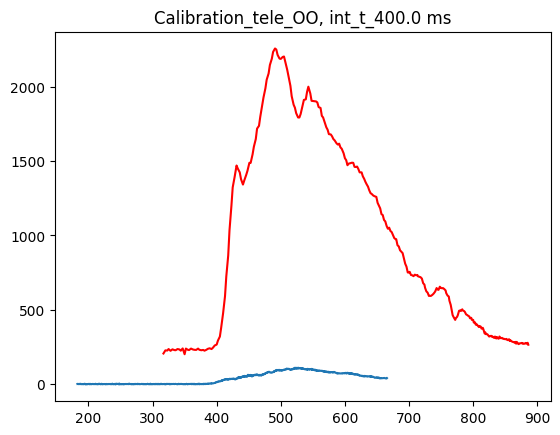

In [72]:
plt.plot(wavelengths,blue_430nm_400ms_no_dark_noise,label='OO')
plt.plot(nm,data,color='r',label='tele')
plt.title('Calibration_tele_OO, int_t_{} ms'.format(t_int_s*1000))

In [74]:
x_min = np.min(nm)
x_max = np.max(wavelengths)

Text(0.5, 1.0, 'Calibration_tele_OO, int_t_400.0 ms')

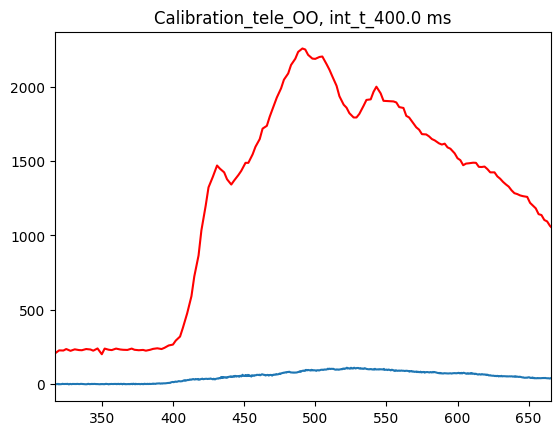

In [75]:
plt.plot(wavelengths,blue_430nm_400ms_no_dark_noise,label='OO')

plt.plot(nm,data,color='r',label='tele')
plt.xlim(x_min,x_max)
plt.title('Calibration_tele_OO, int_t_{} ms'.format(t_int_s*1000))